# Canny Edge Detection by Yunhao Cao
Ref:
https://www.youtube.com/watch?v=sRFM5IEqR2w
https://medium.com/@mrhwick/simple-lane-detection-with-opencv-bfeb6ae54ec0

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [366]:
# parameters
CANNY_THRESHOLD_1 = 0
CANNY_THRESHOLD_2 = 200
HOUGH_RHO = 6
HOUGH_THETA = np.pi / 60
HOUGH_THRESHOLD = 100
HOUGH_MINLINELENGTH = 30
HOUGH_MAXLINEGAP = 20
BLUR_PERCENTAGE = 0.5
FILENAME = 'test.mov'
GROUND_MASK_LOWER = np.array([0,0,80],dtype='uint8')
GROUND_MASK_UPPER = np.array([255,50,200],dtype='uint8')
GRASS_MASK_LOWER = np.array([43,50,20],dtype='uint8')
GRASS_MASK_UPPER = np.array([128,255,255],dtype='uint8')

In [356]:
vid = cv.VideoCapture(FILENAME)
print(vid.isOpened())

True


In [364]:
#https://stackoverflow.com/questions/41138000/fit-quadrilateral-tetragon-to-a-blob
#https://medium.com/analytics-vidhya/building-a-lane-detection-system-f7a727c6694
dilkernel = np.ones((5,5), np.uint8)
erokernel = np.ones((6,6), np.uint8)
erokernel[:2,:] = 0
erokernel[-2:,:] = 0
erokernel[:,:2]=0
erokernel[:,-2:]=0
def groundAndGrassMask(image):
    hsvImg = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    
    ground = cv.inRange(hsvImg,GROUND_MASK_LOWER,GROUND_MASK_UPPER)
    grass = cv.inRange(hsvImg,GRASS_MASK_LOWER,GRASS_MASK_UPPER)
    
    grass = cv.erode(grass,erokernel,iterations=2)
    ground = cv.erode(ground,erokernel,iterations=2)
    ground = cv.dilate(ground,dilkernel,iterations=10)
    grass = cv.dilate(grass, dilkernel, iterations=10)
    
    combined = cv.bitwise_and(ground,cv.bitwise_not(grass))
    combined = cv.erode(combined,erokernel,iterations=4)
    #combined = cv.dilate(combined,dilkernel,iterations=5)
    
    return ground,grass,combined

def getContour(alpha):
    #https://stackoverflow.com/questions/66753026/opencv-smoother-contour
    contours,hierachy = cv.findContours(alpha,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
    big_contour = max(contours, key=cv.contourArea)
    contour_img = np.zeros_like(alpha)
    cv.drawContours(contour_img, [big_contour], 0, 255, -1)
    # apply dilate to connect the white areas in the alpha channel
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (40,40))
    dilate = cv.morphologyEx(contour_img, cv.MORPH_DILATE, kernel)
    cannyEdge = cv.Canny(dilate,CANNY_THRESHOLD_1,CANNY_THRESHOLD_2)
    return dilate,cannyEdge

def distToEdge(imageWidth,imageHeight,pointX,pointY):
    dists = [imageWidth - pointX, pointX, imageHeight-pointY,pointY]
    return min(dists)

def imageMidBottomPoint(image):
    imageHeight, imageWidth = grassGreyImage.shape[:2]
    point = (imageWidth / 2.0, imageHeight)
    return point

def weightedLoss():
    pass

def detectLaneContour(grassGreyImage,startingPoint):
    contours,hierachy = cv.findContours(grass,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
    imageHeight, imageWidth = grassGreyImage.shape[:2]
    startingX, startingY = startingPoint
    for contour in contours:
        pass


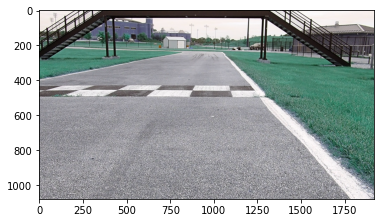

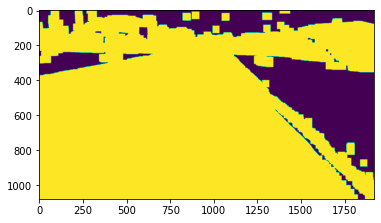

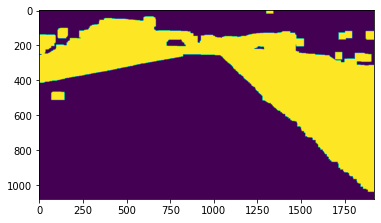

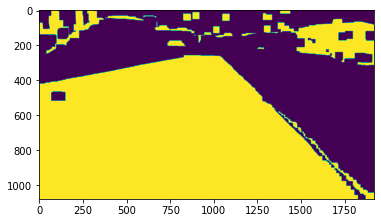

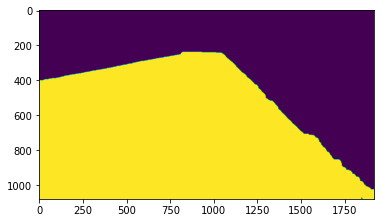

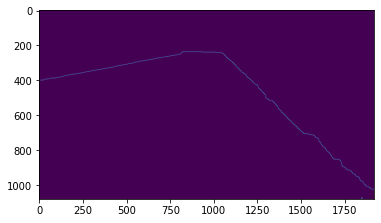

In [365]:
ret, nextImage = vid.read()
if not ret:
    print('no more frames!')
plt.imshow(nextImage)
plt.show()

ground,grass,comb = groundAndGrassMask(nextImage)
plt.imshow(ground)
plt.show()
plt.imshow(grass)
plt.show()
plt.imshow(comb)
plt.show()

dilatedContour, cannyEdge = getContour(comb)
plt.imshow(dilatedContour)
plt.show()
plt.imshow(cannyEdge)
plt.show()

In [344]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    # If there are no lines to draw, exit.
    if lines is None:
        return    # Make a copy of the original image.
    img = np.copy(img)    # Create a blank image that matches the original in size.
    line_img = np.zeros(
        (
            img.shape[0],
            img.shape[1],
            3
        ),
        dtype=np.uint8,
    )    # Loop over all lines and draw them on the blank image.
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv.line(line_img, (x1, y1), (x2, y2), color, thickness)    # Merge the image with the lines onto the original.
    img = cv.addWeighted(img, 0.8, line_img, 1.0, 0.0)    # Return the modified image.
    return img

In [217]:
def isProperLineSegment(seg,acceptedAngleMin = np.pi/4,acceptedAngleMax = np.pi/4*3):
    x1,y1,x2,y2 = seg
    o = y2 - y1
    a = x2 - x1
    angle = np.arctan2(o,a)
    if angle < 0:
        angle += np.pi
    if angle < acceptedAngleMin or angle > acceptedAngleMax:
        return False
    return True

def isProperLine(line,acceptedAngleMin = np.pi/10.,acceptedAngleMax = np.pi/10.*9.):
    totalAngle = 0
    for seg in line:
        x1,y1,x2,y2 = seg
        o = y2 - y1
        a = x2 - x1
        angle = np.arctan2(o,a)
        if angle < 0:
            angle += np.pi
        totalAngle += angle
    avgAngle = totalAngle / len(line)
    if avgAngle < acceptedAngleMin or avgAngle > acceptedAngleMax:
        return False
    return True

def filterLines(lines):
    newLines = []
    for line in lines:
        if isProperLine(line):
            newLines.append(line)
    return newLines

In [218]:
def filterLane(img):
    blurRadius = int(round(min(img.shape[0],img.shape[1])*BLUR_PERCENTAGE/100.))
    
    if blurRadius > 0:
        blurred = cv.GaussianBlur(img, (blurRadius,blurRadius),0);
    else:
        blurred= img.copy()
    
    oneChannelImg = cv.cvtColor(blurred, cv.COLOR_RGB2GRAY)
    #oneChannelImg = blurred[:,:,1]
    cannyEdge = cv.Canny(oneChannelImg,CANNY_THRESHOLD_1,CANNY_THRESHOLD_2)
    raw_lines = cv.HoughLinesP(
        cannyEdge,
        rho=HOUGH_RHO,
        theta=HOUGH_THETA,
        threshold=HOUGH_THRESHOLD,
        minLineLength=HOUGH_MINLINELENGTH,
        maxLineGap=HOUGH_MAXLINEGAP
    )
    lines = filterLines(raw_lines)
    
    return lines,blurred,oneChannelImg,cannyEdge,raw_lines

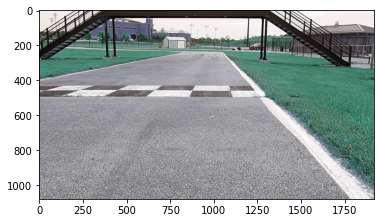

[[174 255 255]
 [174 255 255]
 [173 255 255]
 ...
 [173  43 255]
 [173  49 255]
 [173  58 255]]


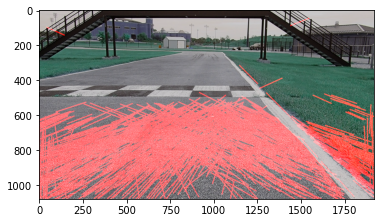

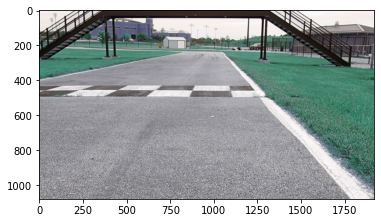

(1080, 1920)


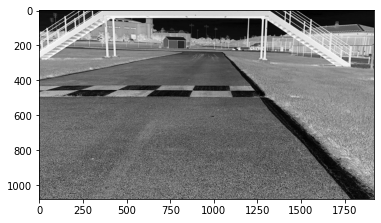

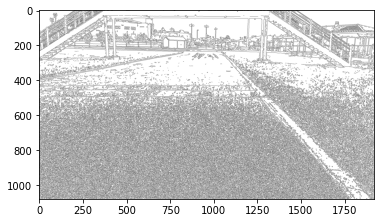

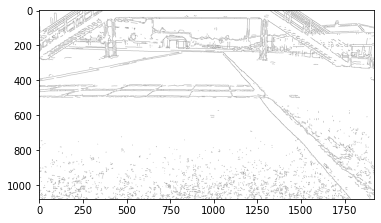

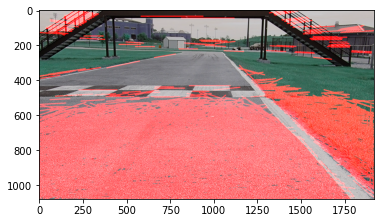

In [214]:
ret, nextImage = vid.read()
if not ret:
    print('no more frames!')
plt.imshow(nextImage)
plt.show()

HSV = cv.cvtColor(nextImage, cv.COLOR_RGB2HSV)
print(np.max(HSV,axis=1))

lines,blurred,one_channel,canny,raw_lines = filterLane(nextImage)

lineDrawed = draw_lines(nextImage,lines)
plt.imshow(lineDrawed)
plt.show()


plt.imshow(blurred)
plt.show()
print(one_channel.shape)
plt.imshow(one_channel,cmap=plt.cm.binary)
plt.show()
plt.imshow(canny,cmap=plt.cm.binary)
plt.show()
plt.imshow(denoised,cmap=plt.cm.binary)
plt.show()
rawLinesDrawed = draw_lines(nextImage,raw_lines)
plt.imshow(rawLinesDrawed)
plt.show()